In [1]:
# Import packages
from umap import UMAP
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats 
from scipy.linalg import orthogonal_procrustes

# Load UMAP functions
%run UMAP_functions.ipynb

In [ ]:
### Load universal data ###
struct_data = sio.loadmat('/SET/YOUR/PATH/umap_input_data.mat') # Set path to input data
struct_data = struct_data['mat']
# Initialize an empty list to store the field data
field_data_list = []
# Iterate over each field in the struct
for field_name in struct_data.dtype.names:
    # Extract the 2-dimensional array from each field
    field_data = struct_data[field_name][0]
    # Flatten the nested arrays
    field_data_flat = np.concatenate(field_data).ravel()
    # Append the flattened field data to the list
    field_data_list.append(field_data_flat)
# Create the DataFrame from the list of flattened field data
data_all = pd.DataFrame(field_data_list).transpose()

# Add column names
colnames = ['age','global_efficiency','path_length', 'small_worldness','strength',
            'modularity', 'core/periphery', 'score', 'local_efficiency', 
            'clustering', 'betweenness', 'subgraph_centrality']
data_all.columns = colnames

### Age Group averages ###
data = data_all.groupby('age').mean().reset_index()
# Remove age column for umap
ages = data['age']
data = data.drop(['age'],axis=1)

In [3]:
### Standardize the data ###
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

In [4]:
# Create UMAPs with different parameters (this can take a few minutes to run)
UMAP_results = umap_grid_search(standardized_data,metric = 'euclidean',
                 n_components = 3,random_state = 42,
                 n_neighbors_range = range(2, 90),
                 min_dist_range = np.linspace(0.1, 1.0, num=11))

In [5]:
turning_point_results = calculate_turning_points(UMAP_results, ages, 
                         degree=5, age_window=5, 
                         gradient_window=5,gradient_threshold=0.8)

In [6]:
# Print summary of turning points
print(f"Number of turning points identified across all manifolds: {turning_point_results['num_turning_points']}")
print(f"Major turning points: {turning_point_results['major_turning_points']}")
print(f"Number of times each turning point was identified: {turning_point_results['turning_point_count']}")

Number of turning points identified across all manifolds: 4997
Major turning points: [ 9. 32. 66. 83.]
Number of times each turning point was identified: [241, 97, 44, 111]


In [ ]:
### Figure 3c ###

# Plot KDE
plt.figure(figsize=(6,1.5))
plt.plot(turning_point_results['x_values'], turning_point_results['kde_values'], color='blue', label='KDE',zorder=1)
plt.scatter(turning_point_results['x_values'][turning_point_results['kde_turning_points']], 
            turning_point_results['kde_values'][turning_point_results['kde_turning_points']], 
            color='red', marker='x', s=50,label='Turning Point',zorder=2)
plt.ylabel('Density',color='black',family='Arial', fontsize=20)
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black', labelsize=10)
plt.yticks([0.007,0.015])
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_color('none')
plt.grid(False)
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('turning_pointKDE_plot.png', bbox_inches='tight',dpi=500)
plt.show()

# Plot histogram with KDE
plt.figure(figsize=(6,4))
sns.histplot(turning_point_results['age_values'], kde=True, bins=50, stat='count', color='blue')
plt.xlabel('')
plt.ylabel('')
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.ylabel('Count',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black',labelsize=10)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('turning_point_histKDE_plot.png', bbox_inches='tight',dpi=500) 
plt.show()

In [ ]:
### Figure 3a ###

# Pull an example manifold data
key = (76,0.45999999999999996) # Choose which UMAP to use as visualization
umap_embedding = UMAP_results[key]
manifold = turning_point_results['all_manifolds'][key]
turning_points = turning_point_results['all_turning_points'][key]

# Determine is there are missing ages
missing = missing_numbers(ages)
# Create age range curve
curve_a = np.linspace(min(ages), max(ages), (len(ages)+missing))

# Plot each dimension's fitted line and turning points
fig, axs = plt.subplots(1, 3, figsize=(15, 6.7))  
# Plot for Dimension X
axs[0].scatter(ages, umap_embedding[:,0], s=150, c=ages, cmap='inferno', alpha=0.7, label='Data')
axs[0].plot(curve_a, manifold['x'], linewidth=5,color='black', label='Curve of Best Fit')
axs[0].set_xlabel('Age',color='black',family='Arial', fontsize=25)
axs[0].set_ylabel('Dimension X',color='black',family='Arial', fontsize=25)
axs[0].tick_params(axis='x', colors='black', labelsize=20)
axs[0].tick_params(axis='y', colors='black', labelsize=20)
axs[0].set_xticks([0, 30, 60, 90])
# Plot for Dimension Y
axs[1].scatter(ages, umap_embedding[:,1],  s=150, c=ages, cmap='inferno', alpha=0.7, label='Data')
axs[1].plot(curve_a, manifold['y'], linewidth=5,color='black', label='Curve of Best Fit')
axs[1].set_xlabel('Age',color='black',family='Arial', fontsize=25)
axs[1].set_ylabel('Dimension Y',color='black',family='Arial', fontsize=25)
axs[1].tick_params(axis='x', colors='black', labelsize=20)
axs[1].tick_params(axis='y', colors='black', labelsize=20)
axs[1].set_xticks([0, 30, 60, 90])
# Plot for Dimension Z
scatter = axs[2].scatter(ages, umap_embedding[:, 2],  s=150, c=ages, cmap='inferno', alpha=0.7, label='Data')
line = axs[2].plot(curve_a, manifold['z'], linewidth=5, color='black', label='Curve of Best Fit')[0]
axs[2].set_xlabel('Age', color='black', family='Arial', fontsize=25)
axs[2].set_ylabel('Dimension Z', color='black', family='Arial', fontsize=25)
axs[2].tick_params(axis='x', colors='black', labelsize=20)
axs[2].tick_params(axis='y', colors='black', labelsize=20)
axs[2].set_xticks([0, 30, 60, 90])
plt.tight_layout()  
plt.savefig('manfiold_3plots.png', bbox_inches='tight',dpi=500)  
plt.show()

## Plot 3D manifold ##
fig = go.Figure(go.Scatter3d(
    x=manifold['x'],
    y=manifold['y'],
    z=manifold['z'],
    mode='lines',
    line=dict(
        color='black',
        width=30, 
    ),
    showlegend=False
))

fig.add_trace(go.Scatter3d(
    x=umap_embedding[:,0],
    y=umap_embedding[:,1],
    z=umap_embedding[:,2],
    mode='markers',
    marker=dict(
        size=23,  
        color=ages, 
        colorscale='inferno',
        opacity=0.7,  
    ),
    showlegend=False
))
fig.update_layout(
    font=dict(
    family='Arial', 
    size=15,  
    color='black'),
    scene=dict(
        aspectmode='cube', 
        xaxis=dict(title='Dim X',title_font=dict(size=40)),  
        yaxis=dict(title='Dim Y',title_font=dict(size=40)),
        zaxis=dict(title='Dim Z',title_font=dict(size=40)),
        camera=dict(
            eye=dict(x=2, y=2, z=2.5),
            center=dict(x=0, y=0, z=-.1)
        )
    )
)
desired_dpi = 800
width_inches = 3  # Adjust as needed
height_inches = 2  # Adjust as needed
width_pixels = int(width_inches * desired_dpi)
height_pixels = int(height_inches * desired_dpi)
fig.write_image("full_manifold.png", width=width_pixels, height=height_pixels)
fig.show()

In [ ]:
### Figure 5c ###
line_colors = ['#FF5AAF','#008DF9','#FFC33B','#009F81','#A40122']

# Pull manifold and turning point details
key = (84,0.64)
umap_embedding = UMAP_results[key]
manifold = turning_point_results['all_manifolds'][key]
turning_points = turning_point_results['all_turning_points'][key]

# Create figure
fig = go.Figure()
# Define the segments and colors
segments = [
    (0, 9, line_colors[0]),
    (9, 32, line_colors[1]),
    (32, 66, line_colors[2]),
    (66, 83, line_colors[3]),
    (83, float('inf'), line_colors[4]),
]

# Add each segment to the plot
for start, end, color in segments:
    values = manifold.loc[start:(end-1),] 
    fig.add_trace(go.Scatter3d(
        x=values['x'],
        y=values['y'],
        z=values['z'],
        mode='lines',
        line=dict(
            color=color,
            width=15
        ),
        showlegend=False
    ))

# Add turning points
# Find the corresponding coordinates for the ages to add
points = []
for p in turning_points:
    index = np.where(ages == p)[0]
    if len(index) > 0:
        points.append(manifold.iloc[index])
    else:
        print(f'Not an age: {p}')
# Combine into one DataFrame
points = pd.concat(points, ignore_index=True)

fig.update_layout(
    font=dict(
        family='Arial', 
        size=15,  
        color='black'
    ),
    scene=dict(
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1), 
        xaxis=dict(
            title='',
            showticklabels=False,
            backgroundcolor="rgba(0,0,0,0)"
        ),
        yaxis=dict(
            title='',
            showticklabels=False,
            backgroundcolor="rgba(0,0,0,0)"
        ),
        zaxis=dict(
            title='',
            showticklabels=False,
            backgroundcolor="rgba(0,0,0,0)"
        ),
        camera=dict(
            eye=dict(x=1, y=2, z=-1),
            center=dict(x=0, y=0, z=0)
        )
    ),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)"
)

# Add points at the specified age locations
fig.add_trace(go.Scatter3d(
    x=points['x'],
    y=points['y'],
    z=points['z'],
    mode='markers',
    marker=dict(
        size=10,
        symbol='circle',
        color='black'
    ),
    name='Ages',
    showlegend=False
))
fig.write_image("summary.png",width=1000,height=1000,scale=3)  
fig.show()

In [ ]:
##############################################################################################
##############################################################################################
### Run sex-stratified analysis ###
##############################################################################################
##############################################################################################

In [ ]:
### Load data for sex-stratified projections ###

### Load female data ###
struct_female_data = sio.loadmat('/SET/YOUR/PATH/female_umap_input_data.mat') # Set path to input data
struct_female_data = struct_female_data['mat']
# Initialize an empty list to store the field data
field_data_list = []
# Iterate over each field in the struct
for field_name in struct_female_data.dtype.names:
    # Extract the 2-dimensional array from each field
    field_data = struct_female_data[field_name][0]
    # Flatten the nested arrays
    field_data_flat = np.concatenate(field_data).ravel()
    # Append the flattened field data to the list
    field_data_list.append(field_data_flat)
# Create the DataFrame from the list of flattened field data
female_data = pd.DataFrame(field_data_list).transpose()

### Load male data ###
struct_male_data = sio.loadmat('/SET/YOUR/PATH/male_umap_input_data.mat') # Set path to input data
struct_male_data = struct_male_data['mat']
# Initialize an empty list to store the field data
field_data_list = []
# Iterate over each field in the struct
for field_name in struct_male_data.dtype.names:
    # Extract the 2-dimensional array from each field
    field_data = struct_male_data[field_name][0]
    # Flatten the nested arrays
    field_data_flat = np.concatenate(field_data).ravel()
    # Append the flattened field data to the list
    field_data_list.append(field_data_flat)
# Create the DataFrame from the list of flattened field data
male_data = pd.DataFrame(field_data_list).transpose()

female_data.columns = colnames
male_data.columns = colnames

### Age Group averages ###
female_average_data = female_data.groupby('age').mean().reset_index()
male_average_data = male_data.groupby('age').mean().reset_index()
# Remove age column for umap
female_average_ages = female_average_data['age']
female_average_data = female_average_data.drop(['age'],axis=1)
male_average_ages = male_average_data['age']
male_average_data = male_average_data.drop(['age'],axis=1)

### Standardize sex-stratified data ###
female_scaler = StandardScaler()
female_average_scaled_data = female_scaler.fit_transform(female_average_data)
male_scaler = StandardScaler()
male_average_scaled_data = male_scaler.fit_transform(male_average_data)

In [ ]:
### Sex-stratified projections ###
female_results = umap_grid_search_procrustes(standardized_data,ages,female_average_scaled_data,female_average_ages,metric = 'euclidean',n_components = 3,random_state = 42,n_neighbors_range = range(2, len(female_average_ages)),min_dist_range = np.linspace(0.1, 1.0, num=11))
male_results = umap_grid_search_procrustes(standardized_data,ages,male_average_scaled_data,male_average_ages,metric = 'euclidean',n_components = 3,random_state = 42,n_neighbors_range = range(2, len(male_average_ages)),min_dist_range = np.linspace(0.1, 1.0, num=11))

In [ ]:
female_turning_point_results = calculate_turning_points(female_results, female_average_ages, 
                         degree=5, age_window=5, 
                         gradient_window=5,gradient_threshold=0.8)
                         # Print summary of turning points
print(f"Number of turning points identified across all manifolds: {female_turning_point_results['num_turning_points']}")
print(f"Major turning points: {female_turning_point_results['major_turning_points']}")
print(f"Number of times each turning point was identified: {female_turning_point_results['turning_point_count']}")

In [ ]:
male_turning_point_results = calculate_turning_points(male_results, male_average_ages, 
                         degree=5, age_window=5, 
                         gradient_window=5,gradient_threshold=0.8)
                         # Print summary of turning points
print(f"Number of turning points identified across all manifolds: {male_turning_point_results['num_turning_points']}")
print(f"Major turning points: {male_turning_point_results['major_turning_points']}")
print(f"Number of times each turning point was identified: {male_turning_point_results['turning_point_count']}")

In [ ]:
### Supplementary Figure 5 ###

key = (80,0.1)
umap_embedding = female_results[key]
manifold = female_turning_point_results['all_manifolds'][key]
turning_points = female_turning_point_results['all_turning_points'][key]
print(f"Turning points: {turning_points}")

#
missing = missing_numbers(female_average_ages)
curve_a = np.linspace(min(female_average_ages), max(female_average_ages), (len(female_average_ages)+missing))
#

# Plot manifold with turning points 
fig = go.Figure(data=go.Scatter3d(
    x=manifold['x'],
    y=manifold['y'],
    z=manifold['z'],
    mode='lines', 
    line=dict(
        color=curve_a,
        colorscale='inferno',
        width = 35
    ),
    showlegend=False
))

# Add turning points
# Find the corresponding coordinates for the ages to add
points = []
for p in turning_points:
    index = np.where(ages == p)[0]
    if len(index) > 0:
        points.append(manifold.iloc[index])
    else:
        print(f'Not an age: {p}')
# Combine into one DataFrame
points = pd.concat(points, ignore_index=True)

fig.update_layout(
    font=dict(
    family='Arial', 
    size=10,  
    color='black'),
    scene=dict(
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1), 
        xaxis=dict(title=''),  
        yaxis=dict(title=''),
        zaxis=dict(title=''),
        camera=dict(
            eye=dict(x=1,y=-2,z=2.5) #(x=0,y=1,z=3) #(x=-2,y=-1,z=-3) # (x=4,y=-1,z=2)  #(x=2, y=-1, z=2)
        )
    )
)
# Remove axis ticks and tick labels
fig.update_layout(scene=dict(
    xaxis=dict(
        showticklabels=False,
        ticks='',
        backgroundcolor="rgba(0,0,0,0)"
    ),
    yaxis=dict(
        showticklabels=False,
        ticks='',
        backgroundcolor="rgba(0,0,0,0)"
    ),
    zaxis=dict(
        showticklabels=False,
        ticks='',
        backgroundcolor="rgba(0,0,0,0)"
    )
))
# Add points at the specified age locations
fig.add_trace(go.Scatter3d(
    x=points['x'],
    y=points['y'],
    z=points['z'],
    mode='markers',
    marker=dict(
        size=20,
        symbol='circle',
        color='red' ##### SWTICH
    ),
    name='Ages',
    showlegend=False
))

fig.write_image("female_example.png",width=1000,height=1000,scale=3)  
fig.show()

In [ ]:
### Supplementary Figure 5 ###

# Plot KDE
plt.figure(figsize=(6,1.5))
plt.plot(female_turning_point_results['x_values'], female_turning_point_results['kde_values'], color='blue', label='KDE',zorder=1)
plt.scatter(female_turning_point_results['x_values'][female_turning_point_results['kde_turning_points']], 
            female_turning_point_results['kde_values'][female_turning_point_results['kde_turning_points']], 
            color='red', marker='x', s=50,label='Turning Point',zorder=2)
plt.ylabel('Density',color='black',family='Arial', fontsize=20)
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black', labelsize=10)
plt.yticks([0.007,0.015])
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_color('none')
plt.grid(False)
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('female_turning_pointKDE_plot.png', bbox_inches='tight',dpi=500)
plt.show()

# Plot histogram with KDE
plt.figure(figsize=(6,4))
sns.histplot(female_turning_point_results['age_values'], kde=True, bins=50, stat='count', color='blue')
plt.xlabel('')
plt.ylabel('')
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.ylabel('Count',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black',labelsize=10)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('female_turning_point_histKDE_plot.png', bbox_inches='tight',dpi=500) 
plt.show()

# Plot KDE
plt.figure(figsize=(6,1.5))
plt.plot(male_turning_point_results['x_values'], male_turning_point_results['kde_values'], color='blue', label='KDE',zorder=1)
plt.scatter(male_turning_point_results['x_values'][male_turning_point_results['kde_turning_points']], 
            male_turning_point_results['kde_values'][male_turning_point_results['kde_turning_points']], 
            color='red', marker='x', s=50,label='Turning Point',zorder=2)
plt.ylabel('Density',color='black',family='Arial', fontsize=20)
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black', labelsize=10)
plt.yticks([0.007,0.015])
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_color('none')
plt.grid(False)
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('male_turning_pointKDE_plot.png', bbox_inches='tight',dpi=500)
plt.show()

# Plot histogram with KDE
plt.figure(figsize=(6,4))
sns.histplot(male_turning_point_results['age_values'], kde=True, bins=50, stat='count', color='blue')
plt.xlabel('')
plt.ylabel('')
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.ylabel('Count',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black',labelsize=10)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('male_turning_point_histKDE_plot.png', bbox_inches='tight',dpi=500) 
plt.show()


In [ ]:
##############################################################################################
##############################################################################################
### Run varying degree analysis ###
##############################################################################################
##############################################################################################

Degree: 2, Major Turning: [30.]
Degree: 3, Major Turning: [22. 81.]
Degree: 4, Major Turning: [13. 84.]
Degree: 5, Major Turning: [ 9. 32. 66. 83.]
Degree: 6, Major Turning: [ 9. 27. 55. 86.]
Degree: 7, Major Turning: [ 8. 25. 55. 86.]
Degree: 8, Major Turning: [ 9. 30. 51. 61. 86.]
Degree: 9, Major Turning: [ 8. 28. 50. 86.]
Degree: 10, Major Turning: [ 9. 29. 51. 87.]
Degree: 11, Major Turning: [ 9. 29. 53. 73. 88.]
Degree: 12, Major Turning: [ 9. 29. 51. 74. 88.]


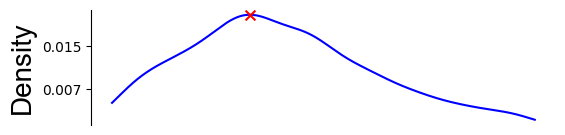

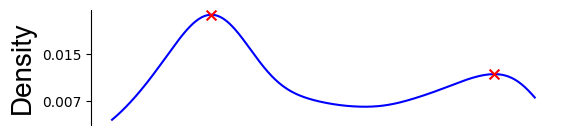

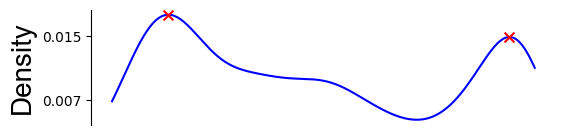

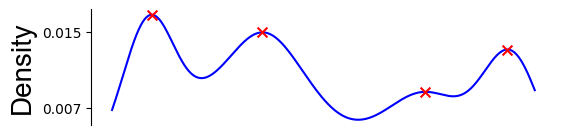

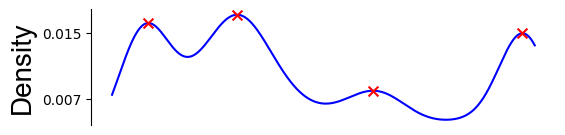

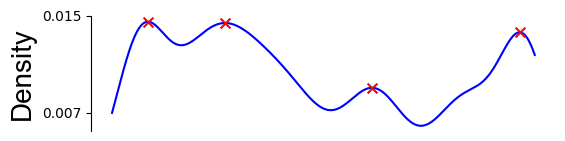

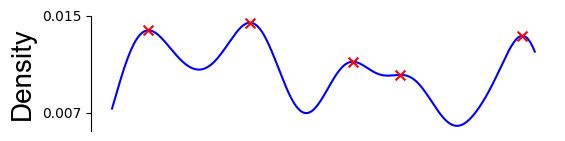

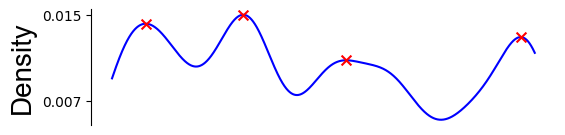

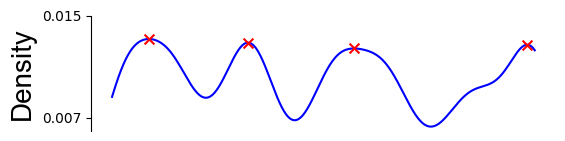

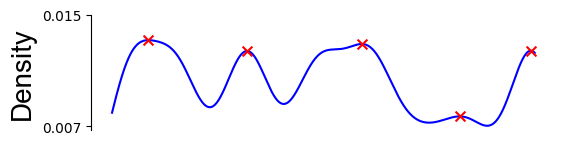

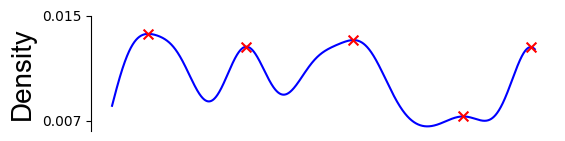

In [ ]:
# Initialise variable to hold all turning points
all_turning_points = []

# Loop through degrees
for d in range(2,13):
    # Rerun with different degrees
    turning_point_results = calculate_turning_points(UMAP_results, ages, 
                            degree=d, age_window=5, 
                            gradient_window=5,gradient_threshold=0.8)
    all_turning_points.append(turning_point_results['age_values'])
    print(f"Degree: {d}, Major Turning: {turning_point_results['major_turning_points']}")

    # Save KDEs
    plt.figure(figsize=(6,1.5))
    plt.plot(turning_point_results['x_values'], turning_point_results['kde_values'], color='blue', label='KDE',zorder=1)
    plt.scatter(turning_point_results['x_values'][turning_point_results['kde_turning_points']], 
                turning_point_results['kde_values'][turning_point_results['kde_turning_points']], 
                color='red', marker='x', s=50,label='Turning Point',zorder=2)
    plt.ylabel('Density',color='black',family='Arial', fontsize=20)
    plt.xlabel('Age',color='black',family='Arial', fontsize=25)
    plt.tick_params(axis='both', which='major', color='black', labelsize=10)
    plt.yticks([0.007,0.015])
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_color('none')
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().spines['right'].set_visible(False) 
    plt.savefig(f'degree_{d}turning_pointKDE_plot.png', bbox_inches='tight',dpi=500)

    # Save line of best fit plots
    if d in [3, 5, 12]:
        # Pull an example manifold data
        key = (76,0.45999999999999996) # Choose which UMAP to use as visualization
        umap_embedding = UMAP_results[key]
        manifold = turning_point_results['all_manifolds'][key]
        turning_points = turning_point_results['all_turning_points'][key]

        # Determine is there are missing ages
        missing = missing_numbers(ages)
        # Create age range curve
        curve_a = np.linspace(min(ages), max(ages), (len(ages)+missing))

        # Plot each dimension's fitted line and turning points
        fig, axs = plt.subplots(1, 3, figsize=(15, 6))  
        # Plot for Dimension X
        axs[0].scatter(ages, umap_embedding[:,0], s=150, c=ages, cmap='inferno', alpha=0.7, label='Data')
        axs[0].plot(curve_a, manifold['x'], linewidth=5,color='black', label='Curve of Best Fit')
        axs[0].set_xlabel('Age',color='black',family='Arial', fontsize=25)
        axs[0].set_ylabel('Dimension X',color='black',family='Arial', fontsize=25)
        axs[0].tick_params(axis='x', colors='black', labelsize=20)
        axs[0].tick_params(axis='y', colors='black', labelsize=20)
        axs[0].set_xticks([0, 30, 60, 90])
        # Plot for Dimension Y
        axs[1].scatter(ages, umap_embedding[:,1],  s=150, c=ages, cmap='inferno', alpha=0.7, label='Data')
        axs[1].plot(curve_a, manifold['y'], linewidth=5,color='black', label='Curve of Best Fit')
        axs[1].set_xlabel('Age',color='black',family='Arial', fontsize=25)
        axs[1].set_ylabel('Dimension Y',color='black',family='Arial', fontsize=25)
        axs[1].tick_params(axis='x', colors='black', labelsize=20)
        axs[1].tick_params(axis='y', colors='black', labelsize=20)
        axs[1].set_xticks([0, 30, 60, 90])
        # Plot for Dimension Z
        scatter = axs[2].scatter(ages, umap_embedding[:, 2],  s=150, c=ages, cmap='inferno', alpha=0.7, label='Data')
        line = axs[2].plot(curve_a, manifold['z'], linewidth=5, color='black', label='Curve of Best Fit')[0]
        axs[2].set_xlabel('Age', color='black', family='Arial', fontsize=25)
        axs[2].set_ylabel('Dimension Z', color='black', family='Arial', fontsize=25)
        axs[2].tick_params(axis='x', colors='black', labelsize=20)
        axs[2].tick_params(axis='y', colors='black', labelsize=20)
        axs[2].set_xticks([0, 30, 60, 90])
        plt.tight_layout()  
        plt.savefig(f'degree{d}_3plots.png', bbox_inches='tight',dpi=500)  
all_turning_points = np.concatenate(all_turning_points).astype(int)

Turning Points: [ 8. 29. 54. 78. 87.]


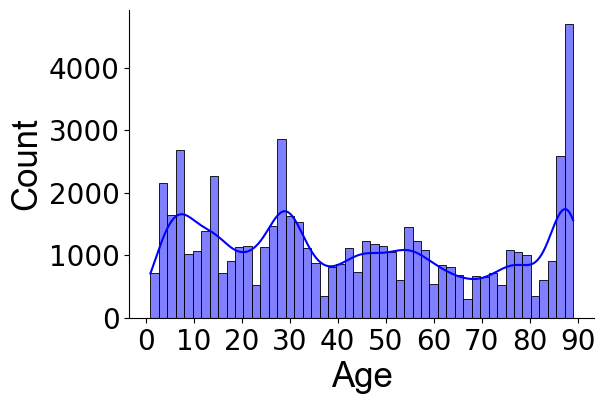

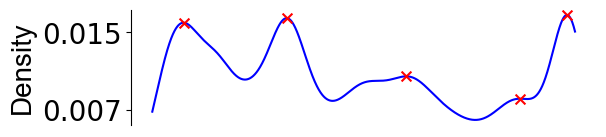

In [8]:
### Calculate turning points from all degree attempts ###

kde = stats.gaussian_kde(all_turning_points)
# Create continues age variable
x_values = np.linspace(min(all_turning_points), max(all_turning_points), len(all_turning_points))
# Calculate the KDE values for the given x_values
kde_values = kde(x_values)
# Compute the gradient of the KDE values to identify turning points
kde_derivative = np.gradient(kde_values)
# Find the indices where the gradients changes sign from positive to negative (high frequency ages)
kde_turning_points = np.where(np.diff(np.sign(kde_derivative)) < 0)[0]
# Find associated age at turning point 
final_turning_points = np.round(x_values[kde_turning_points])
print(f'Turning Points: {final_turning_points}')

# Plot histogram with KDE
plt.figure(figsize=(6,4))
sns.histplot(all_turning_points, kde=True, bins=50, stat='count', color='blue')
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.ylabel('Count',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black',labelsize=20)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('multidegree_turning_point_histKDE_plot.png', bbox_inches='tight',dpi=500) 
    
# Plot KDE
plt.figure(figsize=(6,1.5))
plt.plot(x_values, kde_values, color='blue', label='KDE',zorder=1)
plt.scatter(x_values[kde_turning_points], kde_values[kde_turning_points], color='red', marker='x', s=50,label='Turning Point',zorder=2)
plt.ylabel('Density',color='black',family='Arial', fontsize=20)
plt.xlabel('Age',color='black',family='Arial', fontsize=25)
plt.tick_params(axis='both', which='major', color='black', labelsize=20)
plt.yticks([0.007,0.015])
ax = plt.gca()
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_color('none')

plt.grid(False)
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.savefig('multidegree_turning_pointKDE_plot.png', bbox_inches='tight',dpi=500)  # Save the KDE plot
plt.show()

Age Window: 1, Major Turning: [10. 32. 67. 83.]
Age Window: 2, Major Turning: [10. 32. 66. 83.]
Age Window: 3, Major Turning: [ 9. 32. 66. 83.]
Age Window: 4, Major Turning: [ 9. 32. 66. 83.]
Age Window: 5, Major Turning: [ 9. 32. 66. 83.]
Age Window: 6, Major Turning: [ 9. 32. 66. 83.]
Age Window: 7, Major Turning: [ 9. 32. 66. 83.]
Age Window: 8, Major Turning: [ 9. 32. 66. 83.]
Age Window: 9, Major Turning: [ 9. 33. 66. 83.]
Age Window: 10, Major Turning: [ 9. 33. 66. 83.]


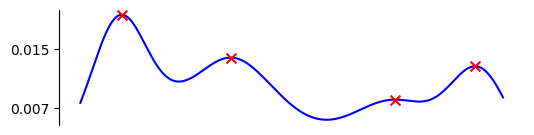

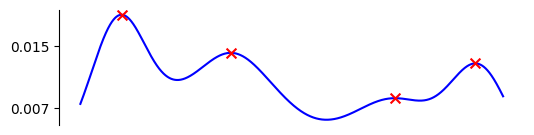

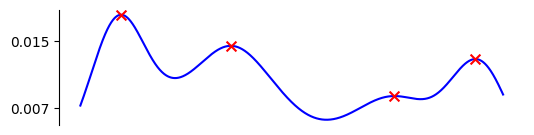

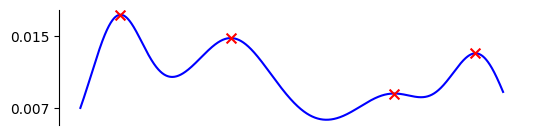

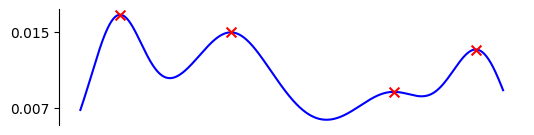

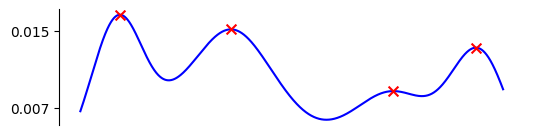

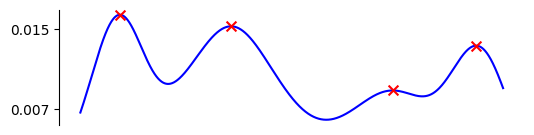

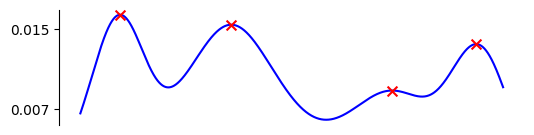

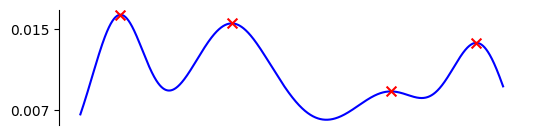

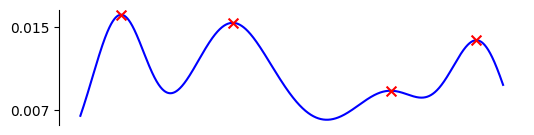

In [9]:
# Loop through age window
for a in range(1,11):
    # Rerun with different degrees
    turning_point_results = calculate_turning_points(UMAP_results, ages, 
                            degree=5, age_window=a, 
                            gradient_window=5,gradient_threshold=0.8)
    print(f"Age Window: {a}, Major Turning: {turning_point_results['major_turning_points']}")

    # Save KDEs
    plt.figure(figsize=(6,1.5))
    plt.plot(turning_point_results['x_values'], turning_point_results['kde_values'], color='blue', label='KDE',zorder=1)
    plt.scatter(turning_point_results['x_values'][turning_point_results['kde_turning_points']], 
                turning_point_results['kde_values'][turning_point_results['kde_turning_points']], 
                color='red', marker='x', s=50,label='Turning Point',zorder=2)
    plt.ylabel('')
    plt.xlabel('')
    plt.tick_params(axis='both', which='major', color='black', labelsize=10)
    plt.yticks([0.007,0.015])
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_color('none')
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().spines['right'].set_visible(False) 
    plt.savefig(f'agewindow_{a}turning_pointKDE_plot.png', bbox_inches='tight',dpi=500)

Gradient Threshold: 0.1, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.2, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.30000000000000004, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.4, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.5, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.6, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.7000000000000001, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.8, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 0.9, Major Turning: [ 9. 32. 66. 83.]
Gradient Threshold: 1.0, Major Turning: [ 8. 54. 84.]
Gradient Threshold: 1.1, Major Turning: [ 8. 54. 84.]
Gradient Threshold: 1.2000000000000002, Major Turning: [ 8. 54. 84.]


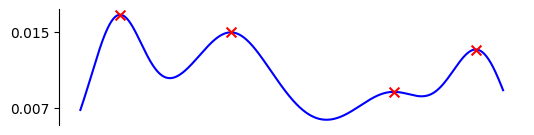

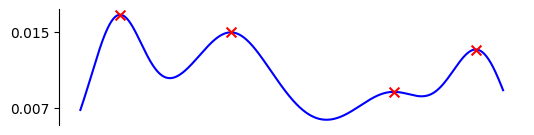

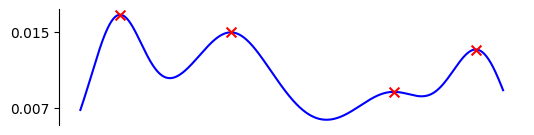

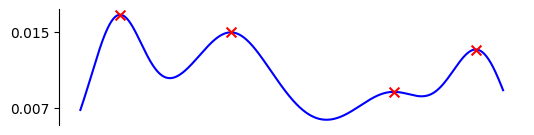

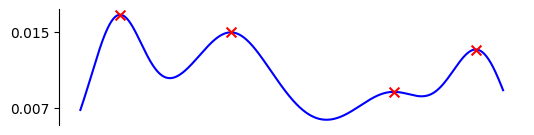

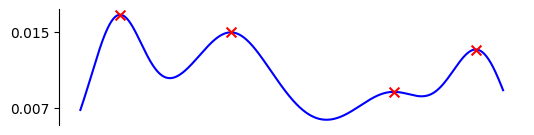

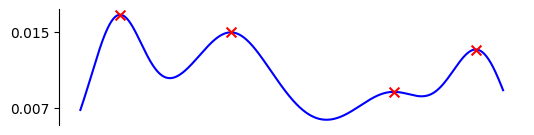

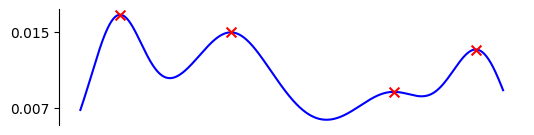

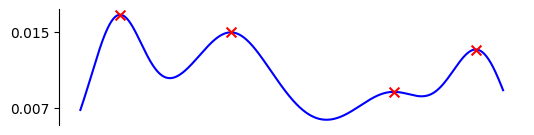

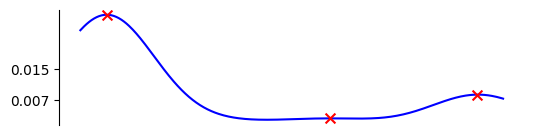

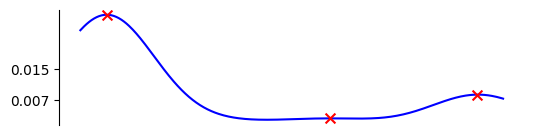

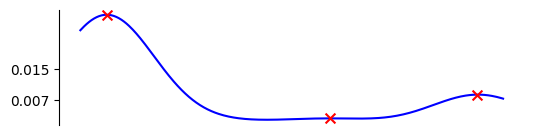

In [10]:
# Loop through gradient threshold
for g in np.arange(0.1, 1.3, 0.1):
    # Rerun with different degrees
    turning_point_results = calculate_turning_points(UMAP_results, ages, 
                            degree=5, age_window=5, 
                            gradient_window=5,gradient_threshold=g)
    print(f"Gradient Threshold: {g}, Major Turning: {turning_point_results['major_turning_points']}")

    # Save KDEs
    plt.figure(figsize=(6,1.5))
    plt.plot(turning_point_results['x_values'], turning_point_results['kde_values'], color='blue', label='KDE',zorder=1)
    plt.scatter(turning_point_results['x_values'][turning_point_results['kde_turning_points']], 
                turning_point_results['kde_values'][turning_point_results['kde_turning_points']], 
                color='red', marker='x', s=50,label='Turning Point',zorder=2)
    plt.ylabel('')
    plt.xlabel('')
    plt.tick_params(axis='both', which='major', color='black', labelsize=10)
    plt.yticks([0.007,0.015])
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_color('none')
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().spines['right'].set_visible(False) 
    plt.savefig(f'gradientThreshold_{g}turning_pointKDE_plot.png', bbox_inches='tight',dpi=500)